## Secondary Structure Prediction of protein sequences using 1D CNN 
This is a very beginner friendly notebook to understand the basics of protein secondary structure prediction using 1D CNN. I am not focusing here to optimize the model (maybe in another notebook), I want to create a small model with 1D CNN layers to predict the secondary structures of a given protein sequence typically classified as H (Helix), E (Sheet) and C (coil). 
This is an example of **sequence-to-sequence** prediction task. 

### Dataset Used:
From Kaggle [Protein Secondary Structure Prediction-2022](https://www.kaggle.com/datasets/kirkdco/protein-secondary-structure-2022/data) 

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 

### Data Preprocessing 
Few things we need to make sure before even going to the model building process:
1. Verify that for every single protein entry, the length of the amino acid sequence string is identical to the length of the secondary structure label string. Discard or fix any entries where they don't match.
2. Check unique characters in amino acid sequence string and secondary structure label string.  
3. Non-standard amino acids and secondary structure labels should be removed or fixed. (In case there is none as indicated by `has_nonstd_aa` = `False`)

In [2]:
df = pd.read_csv("2022-12-17-pdb-intersect-pisces_pc30_r2.5.csv")
df.head(3)

,pdb_id,chain_code,seq,sst8,sst3,len_x,has_nonstd_aa,len_y,method,resol,rfac,freerfac
0,5D8V,A,AAPANAVTADDPTAIALKYNQDATKSERVAAARPGLPPEEQHCANC...,CCCTTBCCTTCHHHHHHTCBSSGGGSCHHHHCCTTSCGGGCCGGGB...,CCCCCECCCCCHHHHHHCCECCHHHCCHHHHCCCCCCHHHCCHHHE...,83,False,83,XRAY,0.48,0.072,0.078
1,3NIR,A,TTCCPSIVARSNFNVCRLPGTPEALCATYTGCIIIPGATCPGDYAN,CEECSSHHHHHHHHHHHTTTCCHHHHHHHHSCEECSSSCCCTTSCC,CEECCCHHHHHHHHHHHCCCCCHHHHHHHHCCEECCCCCCCCCCCC,46,False,46,XRAY,0.48,0.127,NaN
2,5NW3,A,MAKWVCKICGYIYDEDAGDPDNGISPGTKFEELPDDWVCPICGAPK...,CCEEEETTTCCEEETTTCBGGGTBCTTCCGGGSCTTCBCTTTCCBG...,CCEEEECCCCCEEECCCCEHHHCECCCCCHHHCCCCCECCCCCCEH...,54,False,54,XRAY,0.59,0.135,0.146


In [3]:
#check if the seq len = sst3 
len(df['seq']) == len(df['sst3'])

True

In [4]:
df['has_nonstd_aa'].unique()

array([False])

In [5]:
df.columns 

Index(['pdb_id', 'chain_code', 'seq', 'sst8', 'sst3', 'len_x', 'has_nonstd_aa',
       'len_y', 'method', 'resol', 'rfac', 'freerfac'],
      dtype='object')

In [6]:
df.drop(columns=['chain_code','sst8','len_x','len_y','has_nonstd_aa','method','resol','rfac','freerfac'], inplace=True)

### Features and target variable 
1. Features are amino acid sequences `seq`.
2. Target variable is secondary structure labels in this case we have two `sst3` and `sst8`. Here I used `sst3` (3 category secondary structure classification), this is the target output (Y). These strings ( containing 'H', 'E', 'C') represent the ground truth labels for each amino acid in the corresponding `seq` column. `sst8` is the 8 category secondary structure classification. More complex. For now I ignored it

In [7]:
df.head(3)

,pdb_id,seq,sst3
0,5D8V,AAPANAVTADDPTAIALKYNQDATKSERVAAARPGLPPEEQHCANC...,CCCCCECCCCCHHHHHHCCECCHHHCCHHHHCCCCCCHHHCCHHHE...
1,3NIR,TTCCPSIVARSNFNVCRLPGTPEALCATYTGCIIIPGATCPGDYAN,CEECCCHHHHHHHHHHHCCCCCHHHHHHHHCCEECCCCCCCCCCCC
2,5NW3,MAKWVCKICGYIYDEDAGDPDNGISPGTKFEELPDDWVCPICGAPK...,CCEEEECCCCCEEECCCCEHHHCECCCCCHHHCCCCCECCCCCCEH...


### Encoding sequences 
The most important part of the model building process is encoding the sequences and secondary structure labels.  ML models work with numbers and not strings. I used very simple encoding scheme for amino acids and secondary structure labels. 

I used unique integer indices for each possible character for amino acids and secondary structure labels.
```python
Unique amino acids: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X', 'Y']
Unique secondary structure states: ['C', 'E', 'H']
```
Next, padding token `<PAD>` is added to the beginning of the list of amino acids and secondary structure states.  This is done to ensure that all sequences have the same length which is ncessary for batch processing in the model.   

For example: 
```python
Unique amino acids: ['<PAD>', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X', 'Y']
Unique secondary structure states: ['<PAD>', 'C', 'E', 'H']
```
One sequence might have 100 length and another 150. This mismatch prevents stacking them into a single tensor. Padding is added to the shorter sequence to make it 150.  

The `<PAD>` token is given its own unique integer index.  Here, i added to the first index of the list of amino acids and secondary structure states.  During model training and evaluation we tell the model to ignore this padding token.    

In [8]:
##Encoding 
seq_chars = set("".join(df['seq'].tolist())) 
sst3_chars = set("".join(df['sst3'].tolist())) 
print(f'Unique amino acids: {sorted(list(seq_chars))}')
print(f'Unique secondary structure states: {sorted(list(sst3_chars))}')

Unique amino acids: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X', 'Y']
Unique secondary structure states: ['C', 'E', 'H']


In [9]:
##Encoding 
aa_list = sorted(list(seq_chars))
ss_list = sorted(list(sst3_chars)) 

PAD_TOKEN = '<PAD>'
aa_list_pad = [PAD_TOKEN] + aa_list
ss_list_pad = [PAD_TOKEN] + ss_list 

#creating mappings 
aa_to_idx = {aa: idx for idx, aa in enumerate(aa_list_pad)}
ss_to_idx = {ss: idx for idx, ss in enumerate(ss_list_pad)}

#reverse mappings 
aa_idx_to_aa = {idx: aa for idx, aa in enumerate(aa_list_pad)}
ss_idx_to_ss = {idx: ss for idx, ss in enumerate(ss_list_pad)}

PAD_ID_AA = aa_to_idx[PAD_TOKEN]
PAD_ID_SS = ss_to_idx[PAD_TOKEN]

print("AA Vocab Size:", len(aa_list_pad))
print("SST3 Vocab Size:", len(ss_list_pad))
print("AA PAD ID:", PAD_ID_AA)
print("SST3 PAD ID:", PAD_ID_SS) 


AA Vocab Size: 22
SST3 Vocab Size: 4
AA PAD ID: 0
SST3 PAD ID: 0


In [10]:
aa_to_idx

{'<PAD>': 0,
 'A': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'K': 9,
 'L': 10,
 'M': 11,
 'N': 12,
 'P': 13,
 'Q': 14,
 'R': 15,
 'S': 16,
 'T': 17,
 'V': 18,
 'W': 19,
 'X': 20,
 'Y': 21}

In [46]:
ss_to_idx 

{'<PAD>': 0, 'C': 1, 'E': 2, 'H': 3}

In [11]:
#add mappings 
df['seq_idx'] = df['seq'].apply(lambda x: [aa_to_idx[aa] for aa in x])
df['ss_idx'] = df['sst3'].apply(lambda x: [ss_to_idx[ss] for ss in x]) 

In [12]:
print(df[['seq', 'seq_idx', 'sst3', 'ss_idx']].head()) 

                                                 seq  \
0  AAPANAVTADDPTAIALKYNQDATKSERVAAARPGLPPEEQHCANC...   
1     TTCCPSIVARSNFNVCRLPGTPEALCATYTGCIIIPGATCPGDYAN   
2  MAKWVCKICGYIYDEDAGDPDNGISPGTKFEELPDDWVCPICGAPK...   
3  NKASVVANQLIPINTALTLIMMKAEVVTPMGIPAEEIPKLVGMQVN...   
4  ATGGYVQQATGQASFTMYSGCGSPACGKAASGFTAAINQLAFGSAP...   

                                             seq_idx  \
0  [1, 1, 13, 1, 12, 1, 18, 17, 1, 3, 3, 13, 17, ...   
1  [17, 17, 2, 2, 13, 16, 8, 18, 1, 15, 16, 12, 5...   
2  [11, 1, 9, 19, 18, 2, 9, 8, 2, 6, 21, 8, 21, 3...   
3  [12, 9, 1, 16, 18, 18, 1, 12, 14, 10, 8, 13, 8...   
4  [1, 17, 6, 6, 21, 18, 14, 14, 1, 17, 6, 14, 1,...   

                                                sst3  \
0  CCCCCECCCCCHHHHHHCCECCHHHCCHHHHCCCCCCHHHCCHHHE...   
1     CEECCCHHHHHHHHHHHCCCCCHHHHHHHHCCEECCCCCCCCCCCC   
2  CCEEEECCCCCEEECCCCEHHHCECCCCCHHHCCCCCECCCCCCEH...   
3  CCCEEEECCCECCCCECCHHHEEEECCCCCCCEHHHHHHHCCCEEC...   
4  CHHHCCCCCEEEEEEEEECCCCCCCCCCCECCCEEEEEHHHHC

In [13]:
df.drop(columns=['seq','sst3'], inplace=True)
df.head()

,pdb_id,seq_idx,ss_idx
0,5D8V,"[1, 1, 13, 1, 12, 1, 18, 17, 1, 3, 3, 13, 17, ...","[1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, ..."
1,3NIR,"[17, 17, 2, 2, 13, 16, 8, 18, 1, 15, 16, 12, 5...","[1, 2, 2, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
2,5NW3,"[11, 1, 9, 19, 18, 2, 9, 8, 2, 6, 21, 8, 21, 3...","[1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, ..."
3,1UCS,"[12, 9, 1, 16, 18, 18, 1, 12, 14, 10, 8, 13, 8...","[1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, ..."
4,3X2M,"[1, 17, 6, 6, 21, 18, 14, 14, 1, 17, 6, 14, 1,...","[1, 3, 3, 3, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, ..."


### Data Spliting 
Now, most of the times we would just randomly split the data into train, validation and test sets. However, in this case we have to be careful. **Many proteins are evolutionary related and have same/similar sequences**. If highly similar proteins end up in both your training and testing sets, your model's test performance will be artificially inflated because it has essentially seen the answers before.

To avoid this, I identified unique proteins (e.g., using PDB IDs or clustering similar sequences). I then split these unique identifiers into train, validation, and test groups (e.g., 70%/15%/15%)and then collected all the data rows corresponding to the identifiers in each group to form your final datasets. 

In [14]:
#data split 
from sklearn.model_selection import train_test_split 
unique_protein_ids = df['pdb_id'].unique()
print(f'Number of unique proteins: {len(unique_protein_ids)}')

Number of unique proteins: 14557


In [15]:
train_ids, test_ids = train_test_split(unique_protein_ids, test_size=0.15, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.15, random_state=42) 

print(f"Number of training proteins: {len(train_ids)}")
print(f"Number of validation proteins: {len(val_ids)}")
print(f"Number of test proteins: {len(test_ids)}") 

Number of training proteins: 10517
Number of validation proteins: 1856
Number of test proteins: 2184


In [16]:
train_df = df[df['pdb_id'].isin(train_ids)].reset_index(drop=True)
val_df = df[df['pdb_id'].isin(val_ids)].reset_index(drop=True)
test_df = df[df['pdb_id'].isin(test_ids)].reset_index(drop=True)

print(f"Number of training samples: {len(train_df)}")
print(f"Number of validation samples: {len(val_df)}")
print(f"Number of test samples: {len(test_df)}")


Number of training samples: 10898
Number of validation samples: 1917
Number of test samples: 2264


In [17]:
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset 

In [18]:
train_df.head(2)

,pdb_id,seq_idx,ss_idx
0,5D8V,"[1, 1, 13, 1, 12, 1, 18, 17, 1, 3, 3, 13, 17, ...","[1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, ..."
1,5NW3,"[11, 1, 9, 19, 18, 2, 9, 8, 2, 6, 21, 8, 21, 3...","[1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, ..."


In [19]:
##Create custom dataset
class ProteinSequenceDataset(Dataset):
    def __init__(self,dataset):
        self.seq = [torch.tensor(seq,dtype=torch.long) for seq in dataset['seq_idx'].tolist()]
        self.labels = [torch.tensor(ss,dtype=torch.long) for ss in dataset['ss_idx'].tolist()] #secondary structure H,C,E 
        assert len(self.seq) == len(self.labels), "Mismatch between number of sequences and labels"
    def __len__(self):
        return len(self.seq)
    
    def __getitem__(self,idx):
        return {'seq':self.seq[idx],'label':self.labels[idx]}

In [20]:
train_dataset = ProteinSequenceDataset(train_df)
val_dataset = ProteinSequenceDataset(val_df)
test_dataset = ProteinSequenceDataset(test_df) 

print("Train dataset size:", len(train_dataset))
sample = train_dataset[0]
print(f"Sample sequence length: {len(sample['seq'])}")
print(f"Sample label length: {len(sample['label'])}")
print(sample['seq'])
print(sample['label']) 

Train dataset size: 10898
Sample sequence length: 83
Sample label length: 83
tensor([ 1,  1, 13,  1, 12,  1, 18, 17,  1,  3,  3, 13, 17,  1,  8,  1, 10,  9,
        21, 12, 14,  3,  1, 17,  9, 16,  4, 15, 18,  1,  1,  1, 15, 13,  6, 10,
        13, 13,  4,  4, 14,  7,  2,  1, 12,  2, 14,  5, 11, 14,  1, 12, 18,  6,
         4,  6,  3, 19,  9,  6,  2, 14, 10,  5, 13,  6,  9, 10,  8, 12, 18, 12,
         6, 19,  2,  1, 16, 19, 17, 10,  9,  1,  6])
tensor([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 2, 1, 1, 3, 3,
        3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 3, 3, 3, 2, 1, 1,
        2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1,
        1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1])


In [21]:
def collate_fn(batch,pad_seq=PAD_ID_AA,pad_label=PAD_ID_SS):
    seqs = [item['seq'] for item in batch]
    ss = [item['label'] for item in batch]
    padded_seqs = pad_sequence(seqs,batch_first=True,padding_value=pad_seq)
    padded_ss = pad_sequence(ss,batch_first=True,padding_value=pad_label)
    return padded_seqs,padded_ss 

In [22]:
dummy_batch = [train_dataset[i] for i in range(4)] 
padded_seqs_batch, padded_labels_batch = collate_fn(dummy_batch)
print(padded_seqs_batch.shape)
print(padded_labels_batch.shape)
print("Example Padded Sequence:", padded_seqs_batch[0])
print("Example Padded Label:", padded_labels_batch[0]) 

torch.Size([4, 180])
torch.Size([4, 180])
Example Padded Sequence: tensor([ 1,  1, 13,  1, 12,  1, 18, 17,  1,  3,  3, 13, 17,  1,  8,  1, 10,  9,
        21, 12, 14,  3,  1, 17,  9, 16,  4, 15, 18,  1,  1,  1, 15, 13,  6, 10,
        13, 13,  4,  4, 14,  7,  2,  1, 12,  2, 14,  5, 11, 14,  1, 12, 18,  6,
         4,  6,  3, 19,  9,  6,  2, 14, 10,  5, 13,  6,  9, 10,  8, 12, 18, 12,
         6, 19,  2,  1, 16, 19, 17, 10,  9,  1,  6,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
Example Padded Label: tensor([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 2, 1, 1, 3, 3,
        3, 1, 1, 3, 3, 3, 3, 1

In [23]:
##dataloaders 
train_loader = DataLoader(train_dataset,batch_size=8,shuffle=True,collate_fn=collate_fn)
val_loader = DataLoader(val_dataset,batch_size=8,shuffle=False,collate_fn=collate_fn)
test_loader = DataLoader(test_dataset,batch_size=8,shuffle=False,collate_fn=collate_fn) 

In [24]:
sample_batch = next(iter(train_loader))
print(sample_batch[0].shape)
print(sample_batch[1].shape)

torch.Size([8, 784])
torch.Size([8, 784])


## Model 
I made a simple model with activations and 1D CNN blocks and get the logits as output. The model looks like this:

Embedding -> Dropout -> (1D CNN -> RELU -> Dropout -> ) -> (1D CNN -> RELU -> Dropout -> ) -> (1D CNN -> RELU -> Dropout -> ) -> FC -> Logits 


- Embedding -> Dropout: The initial embedding is followed immediately by dropout 
- (...) -> (...) -> (...): The sequence of Convolutional layer (with a specific kernel size), ReLU activation, and Dropout repeats three times, once for each kernel size (3, 4, and 5).
- FC -> Logits: The final fully connected layer maps the features to logits. 


In [25]:
## model 
class SecondaryStructurePredictor(nn.Module):
    def __init__(self,aa_vocab_size,num_classes_ss,embed_dim,cnn_channels,kernel_sizes,dropout_rate,pad_idx_aa):
        super().__init__() 
        self.pad_idx_aa = pad_idx_aa
        self.embed_dim = embed_dim 
        self.cnn_channels = cnn_channels 

        #1. Embedding layer 
        self.embeding = nn.Embedding(
            num_embeddings = aa_vocab_size,
            embedding_dim = embed_dim,
            padding_idx = pad_idx_aa
        )

        #2.CNN layer-1d CNN 
        self.conv_layers = nn.ModuleList()
        in_channels = embed_dim 
        for i,k_size in enumerate(kernel_sizes):
            conv_layer = nn.Conv1d(
                in_channels = in_channels,
                out_channels = cnn_channels,
                kernel_size = k_size,
                padding = 'same'
            )
            self.conv_layers.append(conv_layer)
            in_channels = cnn_channels
        
        ##Activation and dropout 
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        
        #output layer 
        self.fc_out = nn.Linear(
            cnn_channels,
            num_classes_ss
        )
    
    #forward pass
    def forward(self,x):
        #apply embedding 
        embedded = self.dropout(self.embeding(x))
        conv_input = embedded.permute(0,2,1) #(batch_size,embed_dim,seq_len) 
        #apply CNN layers 
        conv_output = conv_input 
        for conv_layer in self.conv_layers:
            conv_output = self.dropout(self.activation(conv_layer(conv_output))) #(batch,embed_dim,seq_len) --> (batch,out_channels,seq_len)
        output_features = conv_output.permute(0,2,1) #(batch,out_channels,seq_len) --> (batch,seq_len,out_channels)

        #final layers
        logits = self.fc_out(output_features) #(batch,seq_len,num_classes_ss) 
        return logits


In [26]:
##Hyperparams
VOCAB_AA = len(aa_list_pad)
NUM_CLASSES_SS = len(ss_list_pad) 
EMBEDDING_DIM = 100 
CNN_CHANNELS = 128 
KERNEL_SIZES = [3, 4, 5] #STACK 3 CONV1D LAYERS
DROPOUT_RATE = 0.4

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(device) 

model = SecondaryStructurePredictor(VOCAB_AA, NUM_CLASSES_SS, EMBEDDING_DIM, CNN_CHANNELS, KERNEL_SIZES, DROPOUT_RATE,pad_idx_aa=PAD_ID_AA).to(device) 
model 

cuda


SecondaryStructurePredictor(
  (embeding): Embedding(22, 100, padding_idx=0)
  (conv_layers): ModuleList(
    (0): Conv1d(100, 128, kernel_size=(3,), stride=(1,), padding=same)
    (1): Conv1d(128, 128, kernel_size=(4,), stride=(1,), padding=same)
    (2): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=same)
  )
  (activation): ReLU()
  (dropout): Dropout(p=0.4, inplace=False)
  (fc_out): Linear(in_features=128, out_features=4, bias=True)
)

In [28]:
#test a single forward pass
dummy_seq_batch, _ = next(iter(train_loader))
dummy_seq_batch = dummy_seq_batch.to(device)
print("\nInput shape:", dummy_seq_batch.shape) 

with torch.no_grad(): # No need to calculate gradients for testing
    model.eval() # Set model to evaluation mode
    output_logits = model(dummy_seq_batch)
    model.train() # Set model back to training mode

print("Output logits shape:", output_logits.shape) # Should be [batch_size, seq_len, num_classes_sst3] 


Input shape: torch.Size([8, 483])
Output logits shape: torch.Size([8, 483, 4])


c:\Users\BiswanathSaha\miniconda3\envs\stable\lib\site-packages\torch\nn\modules\conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Convolution.cpp:1037.)
  return F.conv1d(


In [29]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_ID_SS) #ss 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

In [30]:
from sklearn.metrics import accuracy_score 
from tqdm.notebook import tqdm

def train_epoch(model, data_loader, criterion, optimizer, device):
    """Trains the model for one epoch."""
    model.train() # Set model to training mode
    total_loss = 0.0
    # Assuming collate_fn returns (seqs, labels) tuple
    for seqs, labels in data_loader:
        seqs = seqs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(seqs) # Shape: (batch, seq_len, num_classes)

        # Reshape for criterion (e.g., CrossEntropyLoss)
        # Assumes criterion expects (N, C) and (N,) and handles ignore_index
        loss = criterion(outputs.view(-1, outputs.shape[-1]), labels.view(-1))

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(data_loader)  

In [31]:
def evaluate_model(model, data_loader, criterion, device, PAD_ID_SS):
    """Evaluates the model on a given dataset."""
    model.eval() # Set model to evaluation mode
    total_loss = 0.0
    total_correct = 0
    total_items = 0

    with torch.no_grad(): # Disable gradient calculations
        # Assuming collate_fn returns (seqs, labels) tuple
        for seqs, labels in data_loader:
            seqs = seqs.to(device)
            labels = labels.to(device)

            outputs = model(seqs) # Shape: (batch, seq_len, num_classes)

            # Calculate loss (criterion handles ignore_index)
            loss = criterion(outputs.view(-1, outputs.shape[-1]), labels.view(-1))
            total_loss += loss.item()

            # Calculate accuracy, ignoring padding
            preds = torch.argmax(outputs, dim=-1) # Shape: (batch, seq_len)
            mask = (labels != PAD_ID_SS) # Create mask for non-padding tokens

            correct_in_batch = (preds[mask] == labels[mask]).sum().item()
            items_in_batch = mask.sum().item()

            total_correct += correct_in_batch
            total_items += items_in_batch

    avg_loss = total_loss / len(data_loader)
    # Handle potential division by zero if data_loader is empty or all items are padded
    avg_acc = (total_correct / total_items) if total_items > 0 else 0

    return avg_loss, avg_acc 

In [32]:
epochs = 100 
train_losses = []
val_losses = []
val_accuracies = []

for epoch in tqdm(range(epochs)): 
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device,PAD_ID_SS)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

print("Training complete") 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train Loss: 0.8605, Val Loss: 0.7898, Val Accuracy: 0.6508
Epoch 2/100, Train Loss: 0.8175, Val Loss: 0.7802, Val Accuracy: 0.6562
Epoch 3/100, Train Loss: 0.8102, Val Loss: 0.7836, Val Accuracy: 0.6545
Epoch 4/100, Train Loss: 0.8060, Val Loss: 0.7803, Val Accuracy: 0.6560
Epoch 5/100, Train Loss: 0.8042, Val Loss: 0.7728, Val Accuracy: 0.6598
Epoch 6/100, Train Loss: 0.8027, Val Loss: 0.7710, Val Accuracy: 0.6620
Epoch 7/100, Train Loss: 0.8001, Val Loss: 0.7694, Val Accuracy: 0.6618
Epoch 8/100, Train Loss: 0.7993, Val Loss: 0.7984, Val Accuracy: 0.6443
Epoch 9/100, Train Loss: 0.7985, Val Loss: 0.7681, Val Accuracy: 0.6634
Epoch 10/100, Train Loss: 0.7978, Val Loss: 0.7675, Val Accuracy: 0.6634
Epoch 11/100, Train Loss: 0.7978, Val Loss: 0.7689, Val Accuracy: 0.6646
Epoch 12/100, Train Loss: 0.7971, Val Loss: 0.7690, Val Accuracy: 0.6634
Epoch 13/100, Train Loss: 0.7955, Val Loss: 0.7668, Val Accuracy: 0.6645
Epoch 14/100, Train Loss: 0.7958, Val Loss: 0.7648, Val Accu

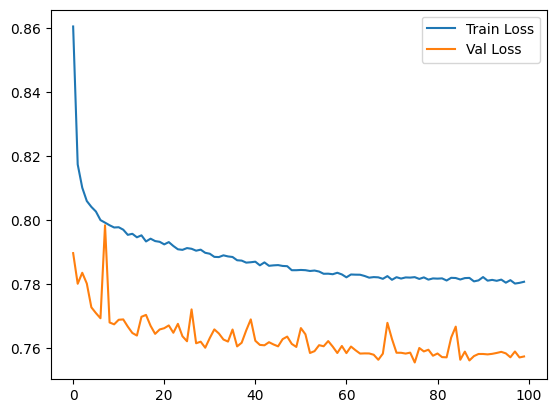

In [33]:
import matplotlib.pyplot as plt 
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

In [36]:
torch.save(model.state_dict(), "secondary_structure_model_epoch_100.pth") # Save the model 

In [34]:
print('Average train loss: ', np.mean(train_losses))
print('Average val loss: ', np.mean(val_losses))
print('Average val accuracy: ', np.mean(val_accuracies))

Average train loss:  0.7880874049724765
Average val loss:  0.7632709107870859
Average val accuracy:  0.6650354963232656


## Interpretation
1. Model does learn from the training data.
2. No Clear overfitting.
3. Performance plateaus after towards the end of 100 epochs.
4. Average per residue accuracy on validation set is around 60%.  Decent result, but not outstanding. of course the model is not that complex.

In [35]:
print("Evaluating on Test Set...")
test_loss, test_acc = evaluate_model(model, test_loader, criterion, device, PAD_ID_SS)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}") 

Evaluating on Test Set...
Test Loss: 0.7576
Test Accuracy: 0.6678


In [44]:
import random

def predict_compare_sample(model,dataset,idx_to_aa,idx_to_ss,device,sample_idx=None):
    if sample_idx is None:
        sample_idx = random.randint(0,len(dataset)-1)
    elif sample_idx >= len(dataset):
        print(f"Warning: sample_idx {sample_idx} is out of bounds for dataset size {len(dataset)}. Using index 0.")
        sample_idx = 0
    
    item = dataset[sample_idx]
    seq_tensor = item['seq']
    label_tensor = item['label']
    seq_len = len(seq_tensor)

    model_inputs = seq_tensor.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        model_outputs = model(model_inputs)
    
    pred_tensor = torch.argmax(model_outputs, dim=-1) 
    pred_tensor = pred_tensor.squeeze(0).cpu().numpy()
    
    original_seq = "".join([idx_to_aa.get(idx.item(),'?') for idx in seq_tensor])
    actual_ss = "".join([idx_to_ss.get(idx.item(),'?') for idx in label_tensor])
    predicted_ss = "".join([idx_to_ss.get(idx.item(),'?') for idx in pred_tensor])

    mismatches = ""
    wrong_idx = []
    for i in range(seq_len):
        if label_tensor[i] == pred_tensor[i]:
            mismatches += " "
        else:
            mismatches += "X"
            wrong_idx.append(i)
    print(f"--- Sample Index: {sample_idx} ---")
    print(f"Length: {seq_len}")
    print(f"Input Sequence: {original_seq}")
    print(f"Actual SS     : {actual_ss}")
    print(f"Predicted SS  : {predicted_ss}")
    print("-" * (len(original_seq) + 18)) 

    correct_preds = (label_tensor == pred_tensor).sum().item()
    accuracy = correct_preds / seq_len
    print(f"Accuracy: {accuracy:.4f}") 

    if wrong_idx:
        print(f"Incorrect prediction indices: {wrong_idx}")
    else:
        print("All predictions correct for this sample.")


In [45]:
predict_compare_sample(model,test_dataset,aa_idx_to_aa,ss_idx_to_ss,device,sample_idx=0)  

--- Sample Index: 0 ---
Length: 133
Input Sequence: GMSNKFLGTWKLVSSENFDDYMKALGVGLATRKLGNLAKPTVIISKKGDIITIRTESTFKNTEISFKLGQEFEETTADNRKTKSIVTLQRGSLNQVQRWDGKETTIKRKLVNGKMVAEXKMKGVVXTRIYEKV
Actual SS     : CCCHHHCEEEEEEEEECHHHHHHHCCCCHHHHHHHHHCCCEEEEEEECCEEEEEEECCCCEEEEEECCCCCEEEECCCCCEEEEEEEEECCEEEEEEEECCEEEEEEEEEECCEEEEEEEECCEEEEEEEEEC
Predicted SS  : CCCCCHECEEEEECCCCHHHHHHHCCCCHHHHHHCCCCCCEEEEECCCCEEEEEECCCCCCCEEEEECCHHHHHCCCCCCCCCEEEEEECCCHHHHEEECCCEEHHHHHHECCHHEHHHHHCCEEEHHHHCCC
-------------------------------------------------------------------------------------------------------------------------------------------------------
Accuracy: 0.6241
Incorrect prediction indices: [3, 4, 6, 7, 13, 14, 15, 34, 35, 36, 45, 46, 55, 60, 61, 66, 69, 70, 71, 72, 73, 74, 80, 81, 82, 91, 92, 93, 94, 95, 101, 104, 105, 106, 107, 108, 109, 113, 114, 116, 117, 118, 119, 120, 126, 127, 128, 129, 130, 131]


Next, I will try to improve the model's performance with hyperparameter tuning with wandb.